In [1]:
# imports
import os
import sys

# Adiciona o diretório raiz do projeto ao PYTHONPATH para importar o pacote local
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
from nasabinning.binning_engine import NASABinner
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
def generate_credit_risk_dataset(
    n: int = 1_000_000,
    seed: int = 42,
    anos_meses_possiveis: list[int] = [202301, 202302, 202303, 202304, 202305]
) -> pd.DataFrame:
    """
    Gera um DataFrame sintético para contexto de risco de crédito.
    
    Parâmetros
    ----------
    n : int
        Número de linhas (clientes) desejadas. Default = 1_000_000.
    seed : int
        Semente para aleatoriedade (reprodutibilidade). Default = 42.
    anos_meses_possiveis : list[int]
        Lista de códigos de referência de mês (AnoMesReferencia) utilizados
        para simular diferentes períodos. Ex.: [202301, 202302, ...].
    
    Retorna
    -------
    pd.DataFrame
        DataFrame com as seguintes colunas:
        - idade (float): idade simulada (média 40, desvio 10).
        - renda (float): renda mensal (média 3000, desvio 800).
        - score (float): score de crédito (média 600, desvio 100).
        - AnoMesReferencia (int): período em formato YYYYMM.
        - num_loans (int): número de empréstimos em aberto (distribuição Poisson).
        - debt_to_income (float): relação dívida / renda (entre 0 e 1).
        - num_credit_inquiries (int): número de consultas ao crédito (Poisson).
        - marital_status (categoria): estado civil.
        - education_level (categoria): nível de escolaridade.
        - employment_type (categoria): tipo de vínculo empregatício.
        - residential_status (categoria): situação de moradia.
        - default_90d (int): variável-alvo binária simulada (0 = sem default, 1 = default em até 90 dias).
    """
    np.random.seed(seed)
    
    # 1) Variáveis numéricas básicas
    idade = np.random.normal(loc=40, scale=10, size=n)
    renda = np.random.normal(loc=3000, scale=800, size=n)
    score = np.random.normal(loc=600, scale=100, size=n)
    
    # Garantir que renda e score não fiquem com valores negativos (se ocorrerem)
    renda = np.clip(renda, a_min=200, a_max=None)  # renda mínima de 200
    score = np.clip(score, a_min=300, a_max=850)   # score entre 300 e 850 (faixa típica)
    idade = np.clip(idade, a_min=18, a_max=90)      # faixa etária entre 18 e 90 anos
    
    # 2) Período de referência (AnoMesReferencia)
    AnoMesReferencia = np.random.choice(anos_meses_possiveis, size=n)
    
    # 3) Variáveis adicionais numéricas
    # Número de empréstimos em aberto (Poisson, média = 2)
    num_loans = np.random.poisson(lam=2, size=n)
    
    # Relação dívida / renda (uniforme entre 0 e 1, mas com tendência central)
    debt_to_income = np.random.beta(a=2, b=5, size=n)  # distrib. beta para dar assimetria
    
    # Número de consultas de crédito nos últimos 6 meses (Poisson, média = 1)
    num_credit_inquiries = np.random.poisson(lam=1, size=n)
    
    # 4) Variáveis categóricas
    # Estado civil
    marital_status = np.random.choice(
        ["Single", "Married", "Divorced", "Widowed"],
        size=n,
        p=[0.4, 0.45, 0.1, 0.05]
    )
    
    # Nível de escolaridade
    education_level = np.random.choice(
        ["High School", "Bachelor", "Master", "PhD", "Other"],
        size=n,
        p=[0.35, 0.4, 0.15, 0.05, 0.05]
    )
    
    # Tipo de emprego
    employment_type = np.random.choice(
        ["Salaried", "Self-employed", "Unemployed", "Retired"],
        size=n,
        p=[0.6, 0.15, 0.2, 0.05]
    )
    
    # Status residencial
    residential_status = np.random.choice(
        ["Rent", "Own", "Mortgage"],
        size=n,
        p=[0.5, 0.3, 0.2]
    )
    
    # 5) Montagem do DataFrame
    df = pd.DataFrame({
        "idade": idade,
        "renda": renda,
        "score": score,
        "AnoMesReferencia": AnoMesReferencia,
        "num_loans": num_loans,
        "debt_to_income": debt_to_income,
        "num_credit_inquiries": num_credit_inquiries,
        "marital_status": marital_status,
        "education_level": education_level,
        "employment_type": employment_type,
        "residential_status": residential_status,
    })
    
    # 6) Variável-alvo (default em até 90 dias)
    # Critério simplificado: maior chance de default se score baixo, renda baixa e dívida alta.
    # Calculamos uma pontuação de risco parcial e adicionamos componente aleatório.
    # Primeiro, normalizamos score e renda para 0–1:
    score_norm = (df["score"] - df["score"].min()) / (df["score"].max() - df["score"].min())
    renda_norm = (df["renda"] - df["renda"].min()) / (df["renda"].max() - df["renda"].min())
    
    # Uma “pontuação de risco” arbitrária (quanto maior, mais propenso a default)
    risk_score = (1 - score_norm) * 0.4 + (1 - renda_norm) * 0.3 + df["debt_to_income"] * 0.2 \
                 + (df["num_loans"] / (df["num_loans"].max() + 1)) * 0.1
    
    # Transformar em probabilidade pelo mapa logístico simplificado:
    # prob_default ∈ (0, 1), depois comparamos com uniforme para definir 0/1.
    prob_default = 1 / (1 + np.exp(-3 * (risk_score - 0.5)))
    
    default_90d = (np.random.rand(n) < prob_default).astype(int)
    df["default_90d"] = default_90d
    
    return df

df = generate_credit_risk_dataset(n=1_000_000, seed=42)
print(df.shape)
display(df.head())

(1000000, 12)


,idade,renda,score,AnoMesReferencia,num_loans,debt_to_income,num_credit_inquiries,marital_status,education_level,employment_type,residential_status,default_90d
0,44.967142,3135.337484,706.472241,202301,1,0.524953,2,Single,Master,Unemployed,Own,0
1,38.617357,2902.795875,550.328682,202304,0,0.093070,1,Divorced,High School,Salaried,Rent,0
2,46.476885,3925.300219,612.926020,202301,2,0.726887,2,Married,High School,Self-employed,Own,0
3,55.230299,3160.068631,452.030663,202304,1,0.385445,3,Married,Bachelor,Salaried,Rent,0
4,37.658466,3691.688555,569.015270,202305,2,0.300789,1,Married,High School,Salaried,Rent,1


In [6]:
# usar NASABinner sem Optuna
binner = NASABinner(
    strategy="supervised",
    max_bins=5,
    min_event_rate_diff=0.01,
    monotonic=None,
    use_optuna=False,
    check_stability=True
)

# ainda nao consegue lidar com feature categorica
X = df[["idade", "renda", "score", "debt_to_income"]]
y = df["default_90d"]
binner.fit(X, y, time_col="AnoMesReferencia")

print("IV:", round(binner.iv_, 4))
display(binner._bin_summary_.head(100))

IV: 0.008


,variable,bin,count,event,non_event,event_rate
0,idade,"(-inf, 24.54)",1000000,445992,554008,0.445992
1,idade,Special,0,0,0,NaN
2,idade,Missing,0,0,0,NaN
3,idade,,1000000,445992,554008,0.445992
4,renda,"(-inf, 1751.43)",59541,29558,29983,0.496431
5,renda,"[1751.43, 2450.66)",186741,88361,98380,0.473174
6,renda,"[2450.66, 3263.69)",382964,172534,210430,0.450523
7,renda,"[3263.69, 4014.13)",268120,114499,153621,0.427044
8,renda,"[4014.13, inf)",102634,41040,61594,0.399867
9,renda,Special,0,0,0,NaN


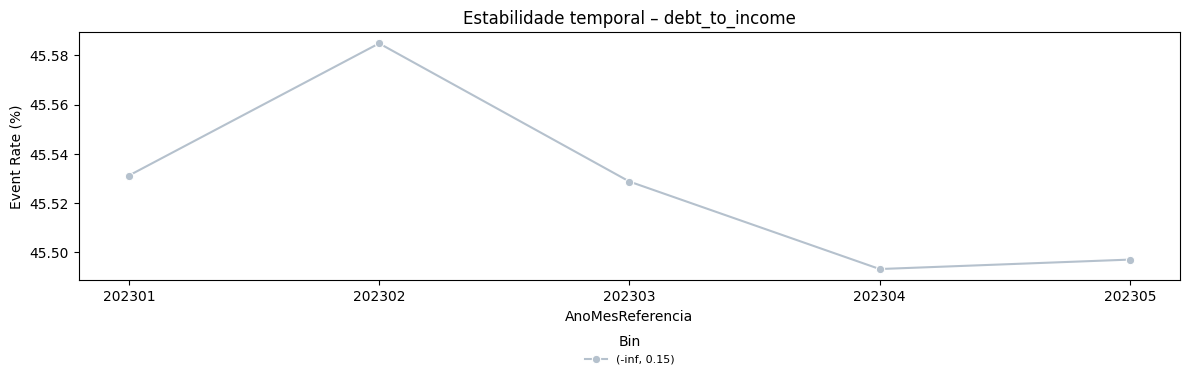

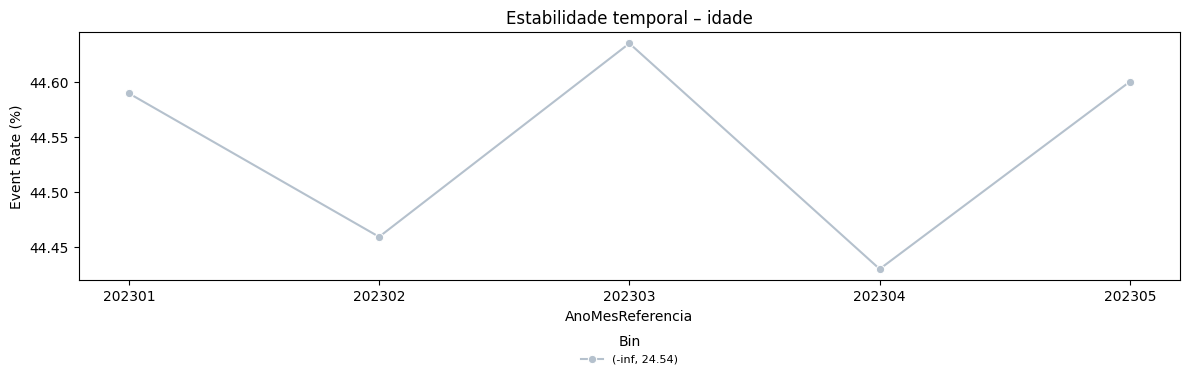

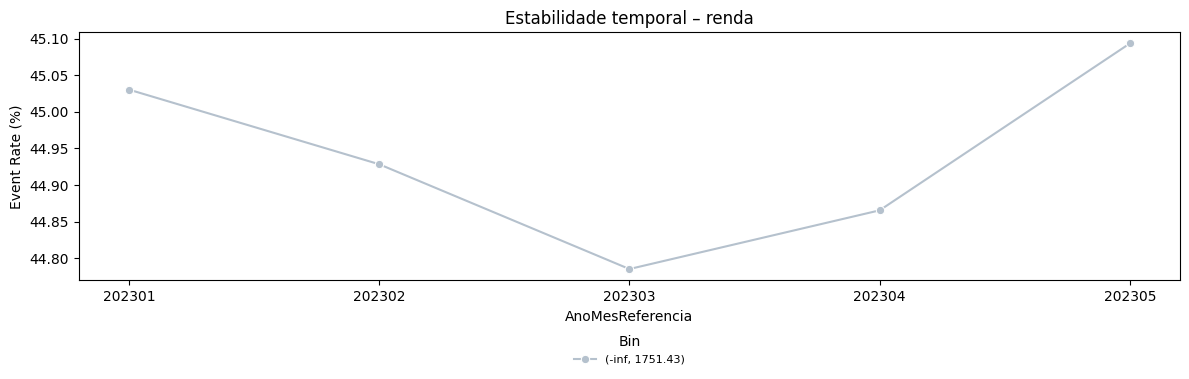

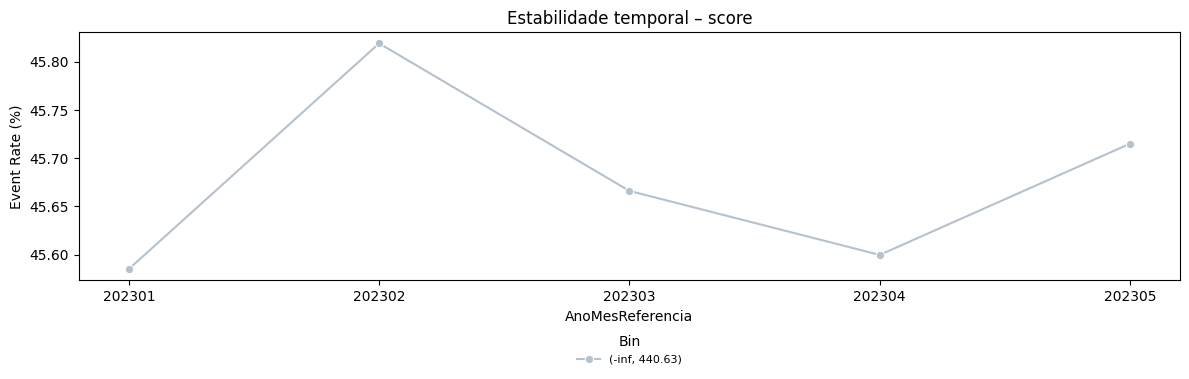

In [5]:
# calcular pivot (já inclui a coluna AnoMesReferencia em X)
pivot = binner.stability_over_time(
    X=df[["idade", "renda", "score","debt_to_income","AnoMesReferencia"]],
    y=df["default_90d"],
    time_col="AnoMesReferencia",
)

binner.plot_event_rate_stability(
    pivot,
    title_prefix="Estabilidade temporal",
    time_col_label="AnoMesReferencia"
)

In [ ]:
# testar NASABinner COM Optuna
binner_opt = NASABinner(
    strategy="supervised",
    use_optuna=True,
    check_stability=True,
    monotonic="descending",     # força tendência decrescente (ex: para score)
    strategy_kwargs={"n_trials": 15}
)
binner_opt.fit(X, y, time_col="AnoMesReferencia")

print("IV:", round(binner_opt.iv_, 4))
print("Melhores parâmetros:", getattr(binner_opt, "best_params_", None))
display(binner_opt._bin_summary_.head())


[I 2025-06-03 00:12:04,547] A new study created in memory with name: no-name-ea32255e-eb1e-43e4-b05b-eed6c577a70f
[W 2025-06-03 00:12:04,550] Trial 0 failed with parameters: {'max_bins': 8, 'min_bin_size': 0.022599114415391117, 'min_event_rate_diff': 0.05461690423069677} because of the following error: TypeError("nasabinning.binning_engine.NASABinner() got multiple values for keyword argument 'min_event_rate_diff'").
Traceback (most recent call last):
  File "c:\Users\JM\AppData\Local\anaconda3\envs\ENV_STONE\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "c:\Users\JM\Documents\0_CienciaDados\1_Frameworks\NASABinning\nasabinning\optuna_optimizer.py", line 63, in <lambda>
    lambda tr: _objective(tr, X, y, base_kwargs, time_col),
  File "c:\Users\JM\Documents\0_CienciaDados\1_Frameworks\NASABinning\nasabinning\optuna_optimizer.py", line 31, in _objective
    binner = NASABinner(
TypeError: nasabinning.binning_engine.NASABi

TypeError: nasabinning.binning_engine.NASABinner() got multiple values for keyword argument 'min_event_rate_diff'

In [ ]:
# plotar estabilidade do modelo com Optuna
binner_opt.plot_event_rate_stability(title="Estabilidade temporal - com Optuna")